1) **Environment & imports**  
Imports PyTorch core, neural network modules, and functional ops.  
Imports EllipticBitcoinDataset and SAGEConv from PyTorch Geometric.  
Imports scikit-learn tools for dataset splitting and classification metrics.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import EllipticBitcoinDataset
from torch_geometric.nn import SAGEConv
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

d:\DL Project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2) **Device setup**  
Sets DEVICE to CPU.  
Prints the chosen device.


In [2]:
DEVICE = torch.device('cpu')
print(f'Using device: {DEVICE}')

Using device: cpu


3) **Load dataset**  
Initializes EllipticBitcoinDataset from the given root path.  
Selects the first graph object and moves it to DEVICE.  
Prints the loaded data object.


In [3]:
dataset = EllipticBitcoinDataset(root='./dataset')
data = dataset[0].to(DEVICE)
print(data)

Data(x=[203769, 165], edge_index=[2, 234355], y=[203769], train_mask=[203769], test_mask=[203769])


4) **Label mask and preprocessing**  
Casts edge_index to long dtype for graph ops.  
Creates a mask marking nodes with valid labels.  
Clones the node labels for later use.


In [4]:
data.edge_index = data.edge_index.to(torch.long)
mask = data.y != -1
labels = data.y.clone()

5) **Train/val/test split**  
Extracts indices of labeled nodes.  
Splits them into train and test sets with stratification.  
Further splits the test portion into validation and test sets.


In [5]:
from sklearn.model_selection import train_test_split
mask_idx = mask.nonzero(as_tuple=True)[0]
train_idx, test_idx = train_test_split(mask_idx.cpu(), test_size=0.3, stratify=labels[mask].cpu(), random_state=42)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, stratify=labels[test_idx].cpu(), random_state=42)

6) **Class count extraction**  
Gathers labels for training nodes.  
Computes class counts using torch.bincount for later balancing or analysis.


In [6]:
train_labels = labels[train_idx]
class_counts = torch.bincount(train_labels)

7) **Class weighting & loss setup**  
Computes inverse-frequency class weights from training label counts.  
Normalizes weights to keep them balanced across classes.  
Prints the final class weights.  
Initializes a weighted CrossEntropyLoss using these weights.


In [7]:
from torch.nn import CrossEntropyLoss

class_weights = 1.0 / class_counts.float()
class_weights = class_weights / class_weights.sum() * len(class_counts)
print("Class weights:", class_weights)

# Cross-entropy with weights
ce_loss_fn = CrossEntropyLoss(weight=class_weights)

Class weights: tensor([0.2854, 2.6383, 0.0763])


8) **GraphSAGE encoder definition**  
Defines a two-layer GraphSAGE encoder with dropout.  
Applies SAGEConv → ReLU → Dropout → SAGEConv.  
Returns the final node embeddings z.


In [8]:
class GraphSAGEEncoder(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, dropout=0.3):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hid_dim)
        self.conv2 = SAGEConv(hid_dim, out_dim)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        z = self.conv2(x, edge_index)
        return z

9) **Classifier definition**  
Wraps the GraphSAGE encoder inside a classification model.  
Applies a Linear layer to encoder outputs to produce class logits.  
Uses dropout before the final Linear layer.  
Returns logits and the learned embeddings z.


In [9]:
class SAGEClassifier(nn.Module):
    def __init__(self, encoder, num_classes, dropout=0.3):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(encoder.conv2.out_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index):
        z = self.encoder(x, edge_index)
        logits = self.classifier(F.dropout(z, p=self.dropout, training=self.training))
        return logits, z

10) **Evaluation function & metrics store**  
Defines a model evaluation routine that computes precision, recall, f1, accuracy, and a per-class report.  
Runs the model in eval mode, gathers predictions on test_idx, and stores all metrics in a dictionary.  
Prints summary stats and detailed class-wise scores.  
Initializes an empty metrics_data container for results.


In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

def evaluate_model(model, data, test_idx, labels, name, metrics_store):
    model.eval()
    with torch.no_grad():
        logits, _ = model(data.x, data.edge_index)
        preds = logits.argmax(dim=1)[test_idx].cpu()
        y_true = labels[test_idx].cpu()

    precision = precision_score(y_true, preds, average='macro', zero_division=0)
    recall = recall_score(y_true, preds, average='macro', zero_division=0)
    f1 = f1_score(y_true, preds, average='macro', zero_division=0)
    acc = accuracy_score(y_true, preds)
    report = classification_report(y_true, preds, output_dict=True, zero_division=0)

    # Save metrics
    metrics_store[name] = {
        "precision": round(precision, 4),
        "recall": round(recall, 4),
        "f1": round(f1, 4),
        "accuracy": round(acc, 4),
        "per_class_report": report
    }

    print(f"✅ {name} Model Results:")
    print(f"  Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | Accuracy: {acc:.4f}\n")
    print(f"  Per-Class Report:")
    for class_label, metrics in report.items():
        if class_label == "accuracy":
            continue
        print(f"    Class {class_label}: Precision: {metrics['precision']:.4f} | Recall: {metrics['recall']:.4f} | F1: {metrics['f1-score']:.4f}")
    return preds
metrics_data = {}

11) **Hyperparameter setup**  
Extracts input feature size and sets hidden, embedding, and class counts.  
Defines learning rate, weight decay, number of training epochs, and reconstruction loss weight.


In [11]:
#Hyperparams
in_dim = data.x.size(1)
hid_dim = 128
emb_dim = 64
num_classes = 3
lr = 0.01
weight_decay = 5e-4
epochs = 100
lambda_recon = 0.1

12) **Model & optimizer initialization**  
Creates the GraphSAGE encoder and wraps it in the classifier.  
Moves both to DEVICE.  
Initializes an Adam optimizer using the model's parameters, learning rate, and weight decay.


In [12]:
encoder = GraphSAGEEncoder(in_dim, hid_dim, emb_dim, dropout=0.3).to(DEVICE)
model_weighted = SAGEClassifier(encoder, num_classes, dropout=0.3).to(DEVICE)
optimizer = torch.optim.Adam(model_weighted.parameters(), lr=lr, weight_decay=weight_decay)

13) **Reconstruction loss function**  
Computes link reconstruction scores using dot products of node embeddings.  
Applies a sigmoid and negative log to form a likelihood-style loss.  
Returns the mean reconstruction loss over all edges.


In [13]:
def recon_loss_from_z(z, edge_index):
    row, col = edge_index
    pos_scores = (z[row] * z[col]).sum(dim=1)
    return -torch.log(torch.sigmoid(pos_scores) + 1e-8).mean()

14) **Training loop with reconstruction loss**  
Runs 100 epochs of training with weighted cross-entropy plus optional reconstruction loss.  
Computes gradients, updates model parameters, and tracks training accuracy.  
Every few epochs, evaluates on the validation split and prints loss and metrics.  
Stores train and validation accuracies for later analysis.


In [14]:
epochs = 100
train_accs, val_accs = [], []

for epoch in range(1, epochs + 1):
    # === TRAIN ===
    model_weighted.train()
    optimizer.zero_grad()

    logits, z_all = model_weighted(data.x, data.edge_index)  # logits: [N, num_classes]

    # select only train nodes (labels 0, 1, or 2)
    loss_ce = ce_loss_fn(logits[train_idx], labels[train_idx])
    rloss = recon_loss_from_z(z_all, data.edge_index) if lambda_recon > 0 else torch.tensor(0.0, device=DEVICE)

    loss = loss_ce + lambda_recon * rloss
    loss.backward()
    optimizer.step()

    # compute training accuracy
    with torch.no_grad():
        preds_train = logits[train_idx].argmax(dim=1).cpu()
        true_train = labels[train_idx].cpu()
        train_acc = (preds_train == true_train).float().mean().item()

    # === VALIDATION ===
    if epoch % 5 == 0 or epoch == 1:
        model_weighted.eval()
        with torch.no_grad():
            logits_eval, _ = model_weighted(data.x, data.edge_index)
            preds_val = logits_eval[val_idx].argmax(dim=1).cpu()
            true_val = labels[val_idx].cpu()
            val_acc = (preds_val == true_val).float().mean().item()

        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | CE: {loss_ce.item():.4f} | Recon: {rloss.item():.4f}")
        print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        print("Val known metrics:")
        print(classification_report(true_val, preds_val, target_names=['licit(0)','illicit(1)','unknown(2)'], zero_division=0))

        train_accs.append(train_acc)
        val_accs.append(val_acc)

Epoch 001 | Loss: 1.1750 | CE: 1.1562 | Recon: 0.1873
Train Acc: 0.5414 | Val Acc: 0.2083
Val known metrics:
              precision    recall  f1-score   support

    licit(0)       0.21      1.00      0.34      6303
  illicit(1)       0.29      0.11      0.16       681
  unknown(2)       0.00      0.00      0.00     23581

    accuracy                           0.21     30565
   macro avg       0.16      0.37      0.17     30565
weighted avg       0.05      0.21      0.07     30565

Epoch 005 | Loss: 0.8718 | CE: 0.8679 | Recon: 0.0394
Train Acc: 0.7284 | Val Acc: 0.7387
Val known metrics:
              precision    recall  f1-score   support

    licit(0)       0.80      0.39      0.52      6303
  illicit(1)       0.11      0.68      0.19       681
  unknown(2)       0.84      0.83      0.84     23581

    accuracy                           0.74     30565
   macro avg       0.59      0.63      0.52     30565
weighted avg       0.82      0.74      0.76     30565

Epoch 010 | Loss: 0.

15) **Final evaluation on test set**  
Evaluates the trained model on test_idx using the evaluation function.  
Computes and prints precision, recall, f1, accuracy, and per-class metrics.  
Stores the results under the key "Weighted" in metrics_data.


In [15]:
evaluate_model(model_weighted, data, test_idx, labels, "Weighted", metrics_data)

✅ Weighted Model Results:
  Precision: 0.6599 | Recall: 0.8505 | F1: 0.7068 | Accuracy: 0.8565

  Per-Class Report:
    Class 0: Precision: 0.7332 | Recall: 0.8050 | F1: 0.7675
    Class 1: Precision: 0.2991 | Recall: 0.8768 | F1: 0.4461
    Class 2: Precision: 0.9473 | Recall: 0.8696 | F1: 0.9068
    Class macro avg: Precision: 0.6599 | Recall: 0.8505 | F1: 0.7068
    Class weighted avg: Precision: 0.8887 | Recall: 0.8565 | F1: 0.8678


tensor([2, 2, 2,  ..., 0, 0, 2])

16) **Known/unknown label separation**  
Clones node labels to DEVICE.  
Creates a mask for nodes labeled 0 or 1 (known classes) and extracts their indices.  
Extracts indices of nodes labeled 2 (unknown class).


In [16]:
# Labels and masks
labels = data.y.clone().to(DEVICE)     # [num_nodes]
# known nodes: classes 0 and 1
known_mask = (labels == 0) | (labels == 1)
known_idx = known_mask.nonzero(as_tuple=True)[0]
# unknown nodes: class 2
unknown_idx = (labels == 2).nonzero(as_tuple=True)[0]

17) **Known-class train/val split & unknown test set**  
Splits known-class nodes into training and validation sets with stratification.  
Converts the resulting indices back to torch tensors on DEVICE.  
Sets unknown-class nodes as the test set for open-set evaluation.  
Prints the sizes of train, val, and unknown test splits.


In [17]:
train_idx, val_idx = train_test_split(
    known_idx.cpu().numpy(),
    test_size=0.2,
    stratify=labels[known_idx].cpu().numpy(),
    random_state=42
)
train_idx = torch.tensor(train_idx, dtype=torch.long, device=DEVICE)
val_idx = torch.tensor(val_idx, dtype=torch.long, device=DEVICE)
test_unknown_idx = unknown_idx.to(DEVICE)

print(f"Train known: {train_idx.size(0)}, Val known: {val_idx.size(0)}, Unknown test: {test_unknown_idx.size(0)}")

Train known: 37251, Val known: 9313, Unknown test: 157205


18) **Class weighting for known-class training**  
Extracts labels for known-class training nodes and computes their class counts.  
Pads counts if a class is missing, then derives normalized inverse-frequency weights.  
Prints counts and weights, and creates a weighted CrossEntropyLoss for the known-class setup.  
Marks the transition into the 3-class pipeline.


In [18]:
# compute class weights from training labels (only known classes)
train_labels = labels[train_idx]
class_counts = torch.bincount(train_labels)
# handle if some class missing in batch (rare)
if class_counts.numel() < 2:
    # ensure 2 classes exist
    tmp = torch.zeros(2, dtype=class_counts.dtype, device=class_counts.device)
    tmp[:class_counts.numel()] = class_counts
    class_counts = tmp
class_weights = 1.0 / class_counts.float()
class_weights = (class_weights / class_weights.sum()) * len(class_counts)
class_weights = class_weights.to(DEVICE)
print("Class counts:", class_counts.cpu().numpy(), "Class weights:", class_weights.cpu().numpy())

ce_loss_fn = nn.CrossEntropyLoss(weight=class_weights)

Class counts: [33615  3636] Class weights: [0.19521624 1.8047837 ]


19) **2-class model setup (known vs unknown)**  
Sets number of output classes to 2 for the known-class classifier.  
Initializes a new GraphSAGE encoder and wraps it in a 2-class SAGEClassifier.  
Creates an Adam optimizer for this model with the chosen learning settings.


In [19]:
num_classes = 2

encoder = GraphSAGEEncoder(in_dim, hid_dim, emb_dim, dropout=0.3).to(DEVICE)
model_known_unknown = SAGEClassifier(encoder, num_classes, dropout=0.3).to(DEVICE)
optimizer = torch.optim.Adam(model_known_unknown.parameters(), lr=lr, weight_decay=weight_decay)

20) **Training loop for 2-class model**  
Runs 100 epochs of training using weighted cross-entropy plus optional reconstruction loss.  
Updates model parameters, computes train accuracy on known classes, and performs periodic validation.  
Prints loss, train accuracy, val accuracy, and a 2-class classification report.  
Stores train and validation accuracies for later comparison.


In [20]:
epochs = 100
train_accs, val_accs = [], []

for epoch in range(1, epochs + 1):
    # === TRAIN ===
    model_known_unknown.train()
    optimizer.zero_grad()
    logits, z_all = model_known_unknown(data.x, data.edge_index)

    loss_ce = ce_loss_fn(logits[train_idx], labels[train_idx])
    rloss = recon_loss_from_z(z_all, data.edge_index) if lambda_recon > 0 else torch.tensor(0.0, device=DEVICE)
    loss = loss_ce + lambda_recon * rloss
    loss.backward()
    optimizer.step()

    # compute train metrics
    with torch.no_grad():
        preds_train = logits[train_idx].argmax(dim=1).cpu()
        true_train = labels[train_idx].cpu()
        train_acc = (preds_train == true_train).float().mean().item()

    # === VALIDATION ===
    if epoch % 5 == 0 or epoch == 1:
        model_known_unknown.eval()
        with torch.no_grad():
            logits_eval, _ = model_known_unknown(data.x, data.edge_index)
            preds_val = logits_eval[val_idx].argmax(dim=1).cpu()
            true_val = labels[val_idx].cpu()
            val_acc = (preds_val == true_val).float().mean().item()

        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | CE: {loss_ce.item():.4f} | Recon: {rloss.item():.4f}")
        print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        print("Val known metrics:")
        print(classification_report(true_val, preds_val, target_names=['licit(0)','illicit(1)'], zero_division=0))

        train_accs.append(train_acc)
        val_accs.append(val_acc)

Epoch 001 | Loss: 0.7856 | CE: 0.7701 | Recon: 0.1550
Train Acc: 0.5509 | Val Acc: 0.9024
Val known metrics:
              precision    recall  f1-score   support

    licit(0)       0.90      1.00      0.95      8404
  illicit(1)       0.00      0.00      0.00       909

    accuracy                           0.90      9313
   macro avg       0.45      0.50      0.47      9313
weighted avg       0.81      0.90      0.86      9313

Epoch 005 | Loss: 0.4668 | CE: 0.4648 | Recon: 0.0197
Train Acc: 0.6484 | Val Acc: 0.7395
Val known metrics:
              precision    recall  f1-score   support

    licit(0)       0.99      0.72      0.83      8404
  illicit(1)       0.26      0.93      0.41       909

    accuracy                           0.74      9313
   macro avg       0.63      0.83      0.62      9313
weighted avg       0.92      0.74      0.79      9313

Epoch 010 | Loss: 0.3189 | CE: 0.3179 | Recon: 0.0101
Train Acc: 0.8546 | Val Acc: 0.8199
Val known metrics:
              preci

21) **Validation evaluation for 2-class model**  
Evaluates the trained known-vs-unknown model on the validation split.  
Computes precision, recall, f1, accuracy, and per-class metrics.  
Stores results under "Known-unknown" in metrics_data and prints the full report.


In [21]:
evaluate_model(model_known_unknown, data, val_idx, labels, "Known-unknown", metrics_data)

✅ Known-unknown Model Results:
  Precision: 0.8886 | Recall: 0.9421 | F1: 0.9131 | Accuracy: 0.9673

  Per-Class Report:
    Class 0: Precision: 0.9902 | Recall: 0.9733 | F1: 0.9817
    Class 1: Precision: 0.7871 | Recall: 0.9109 | F1: 0.8445
    Class macro avg: Precision: 0.8886 | Recall: 0.9421 | F1: 0.9131
    Class weighted avg: Precision: 0.9704 | Recall: 0.9673 | F1: 0.9683


tensor([0, 0, 0,  ..., 0, 0, 0])

22) **Unknown-node scoring & ranking**  
Runs the 2-class model to get probabilities for every node.  
Extracts illicit-class probability for unknown nodes only.  
Ranks unknown nodes by highest illicit probability and selects the top K.  
Prints example indices of the most suspicious unknown nodes.


In [22]:
model_known_unknown.eval()
with torch.no_grad():
    logits_all, _ = model_known_unknown(data.x, data.edge_index)
    probs = F.softmax(logits_all, dim=1)  # probabilities for classes 0 and 1
    # For unknown nodes, get probability of illicit (class 1)
    illicit_probs_unknown = probs[test_unknown_idx, 1].cpu()
    # rank unknowns
    topk = 100
    if illicit_probs_unknown.numel() > topk:
        topk_vals, topk_idx_local = torch.topk(illicit_probs_unknown, topk)
    else:
        topk_vals = illicit_probs_unknown
        topk_idx_local = torch.arange(illicit_probs_unknown.size(0))
    topk_node_indices = test_unknown_idx[topk_idx_local]
    print(f"Top-{topk} suspicious unknown nodes (example indices): {topk_node_indices[:20].cpu().numpy()}")


Top-100 suspicious unknown nodes (example indices): [171261 158079  92296 167094 164860 136142  94779 103726 135833  94475
 141775 173565 157205  99847 136329 151748  54699 116174 111237  95995]


23) **Metric visualization**  
Builds grouped bar charts comparing macro precision, recall, f1, and accuracy across all models.  
Extracts and plots class-1 (illicit) metrics for each model, then repeats the process for class-0 (licit) metrics.  
Uses matplotlib to draw three separate comparison plots with grouped bars.  
Shows visual performance differences between models at both macro and per-class levels.


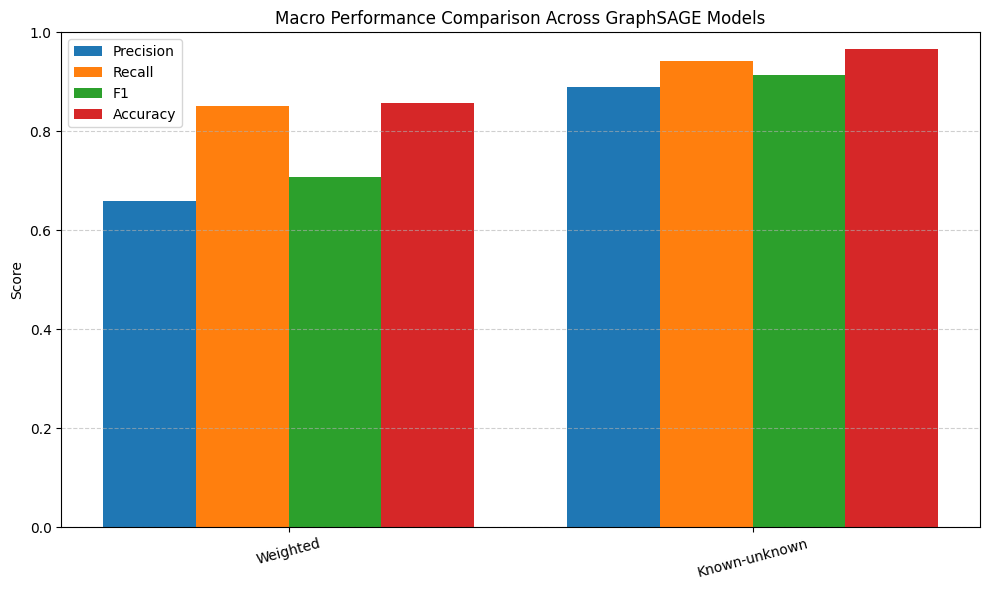

In [23]:
import matplotlib.pyplot as plt
import numpy as np

macro_metrics = ["precision", "recall", "f1", "accuracy"]
models = list(metrics_data.keys())

# Create grouped bar plot
x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(10,6))

for i, metric in enumerate(macro_metrics):
    values = [metrics_data[m][metric] for m in models]
    plt.bar(x + i*width - width*1.5, values, width, label=metric.capitalize())

plt.xticks(x, models, rotation=15)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Macro Performance Comparison Across GraphSAGE Models")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

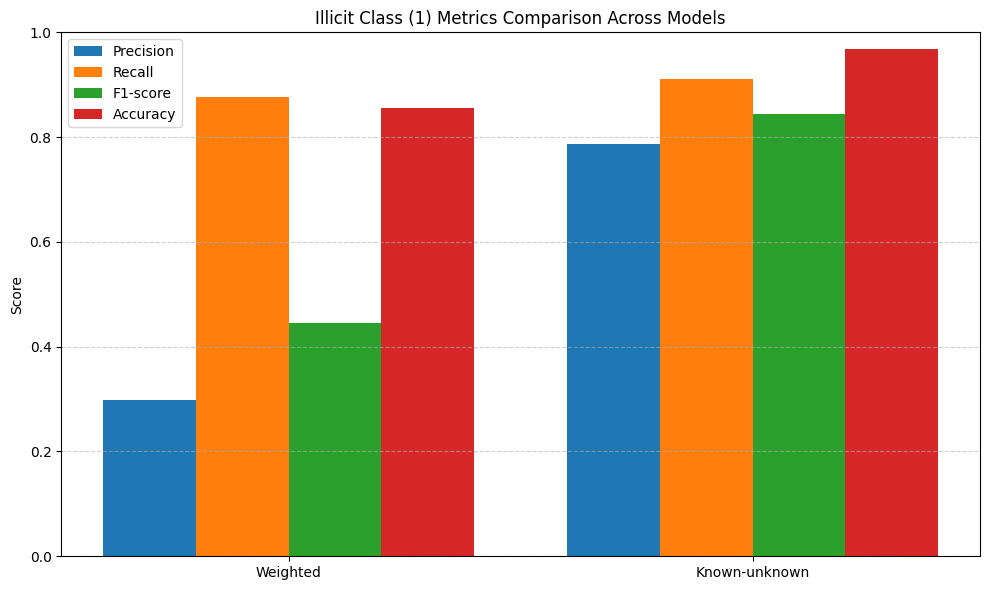

In [24]:
models = list(metrics_data.keys())
metrics_to_plot = ["precision", "recall", "f1-score", "accuracy"]

# Collect values for class 1 + overall accuracy
values_dict = {metric: [] for metric in metrics_to_plot}

for model in models:
    report = metrics_data[model]["per_class_report"]
    # Class 1 metrics
    for metric in ["precision", "recall", "f1-score"]:
        values_dict[metric].append(report.get("1", {}).get(metric, 0.0))
    # Overall accuracy
    values_dict["accuracy"].append(metrics_data[model].get("accuracy", 0.0))

# Plotting
x = np.arange(len(models))
bar_width = 0.2
plt.figure(figsize=(10,6))

for i, metric in enumerate(metrics_to_plot):
    plt.bar(x + i*bar_width - bar_width*1.5, values_dict[metric], width=bar_width, label=metric.capitalize())

plt.xticks(x, models)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Illicit Class (1) Metrics Comparison Across Models")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

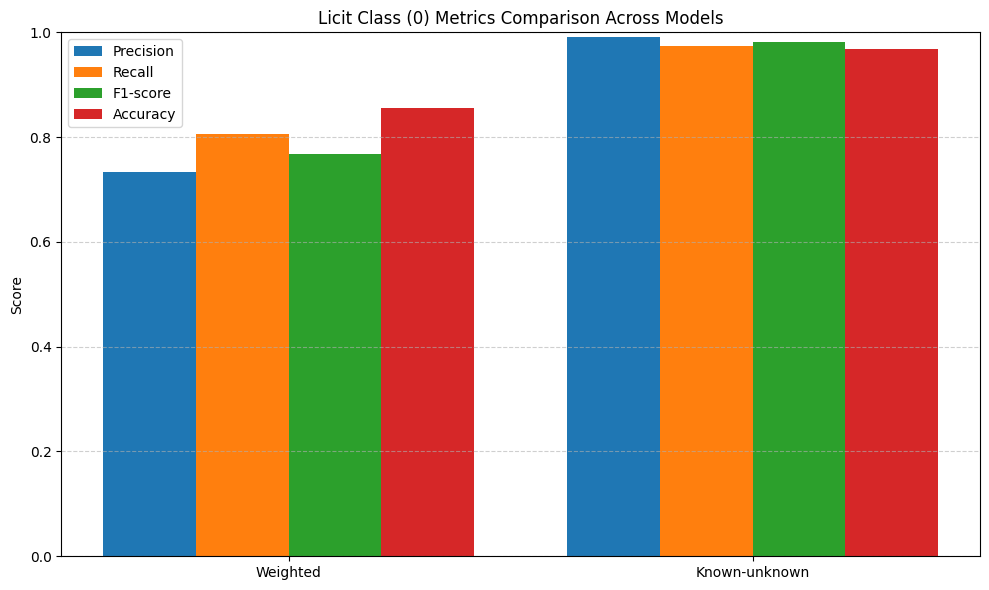

In [25]:
models = list(metrics_data.keys())
metrics_to_plot = ["precision", "recall", "f1-score", "accuracy"]

# Collect values for class 1 + overall accuracy
values_dict = {metric: [] for metric in metrics_to_plot}

for model in models:
    report = metrics_data[model]["per_class_report"]
    # Class 1 metrics
    for metric in ["precision", "recall", "f1-score"]:
        values_dict[metric].append(report.get("0", {}).get(metric, 0.0))
    # Overall accuracy
    values_dict["accuracy"].append(metrics_data[model].get("accuracy", 0.0))

# Plotting
x = np.arange(len(models))
bar_width = 0.2
plt.figure(figsize=(10,6))

for i, metric in enumerate(metrics_to_plot):
    plt.bar(x + i*bar_width - bar_width*1.5, values_dict[metric], width=bar_width, label=metric.capitalize())

plt.xticks(x, models)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Licit Class (0) Metrics Comparison Across Models")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

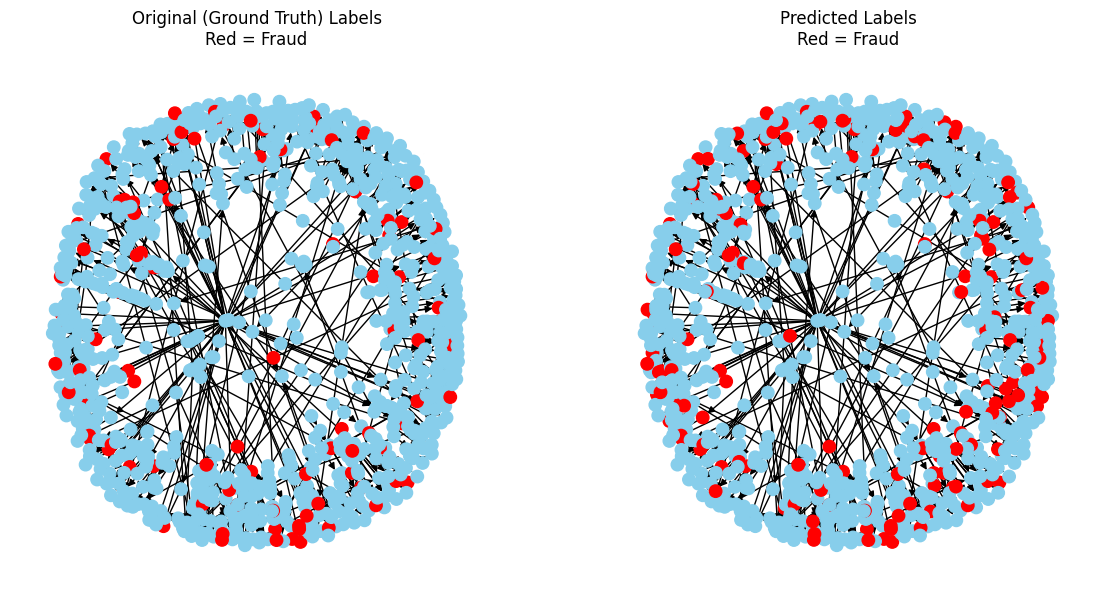

In [30]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Forward pass
logits, _ = model_known_unknown(data.x, data.edge_index)
y_pred = logits.argmax(dim=1)[val_idx].cpu()
y_true = labels[val_idx].cpu()

# Subgraph of first 1000 nodes
mask = (data.edge_index[0] < 1000) & (data.edge_index[1] < 1000)
subgraph_edges = data.edge_index[:, mask]

# Build subgraph
G = nx.DiGraph()
G.add_edges_from(subgraph_edges.t().tolist())

# Extract only nodes that actually exist
nodes_in_graph = sorted(G.nodes())

# Get true and predicted labels for these nodes
true_labels = y_true[nodes_in_graph].cpu().numpy()
pred_labels = y_pred[nodes_in_graph].cpu().numpy()

# ---- Define colors ----
# Assuming fraud = 1, non-fraud = 0
def get_color_array(labels):
    return ['red' if label == 1 else 'skyblue' for label in labels]

true_colors = get_color_array(true_labels)
pred_colors = get_color_array(pred_labels)

# Layout (consistent across both)
pos = nx.spring_layout(G, seed=42)

# Draw side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# --- Ground Truth ---
nx.draw(
    G,
    pos,
    node_color=true_colors,
    with_labels=False,
    node_size=80,
    ax=axes[0],
)
axes[0].set_title("Original (Ground Truth) Labels\nRed = Fraud")

# --- Predictions ---
nx.draw(
    G,
    pos,
    node_color=pred_colors,
    with_labels=False,
    node_size=80,
    ax=axes[1],
)
axes[1].set_title("Predicted Labels\nRed = Fraud")

plt.show()

## Hyperparameter Tuning and Performance Logging
This section performs a structured exploration of key hyperparameters such as learning rate, weight decay, dropout, and reconstruction weight. The results are stored for comparison, focusing on overall accuracy and precision of the illicit class.

In [26]:
import itertools

lr_list = [0.001, 0.005, 0.01]
weight_decay_list = [5e-4, 1e-3, 1e-2]
dropout_list = [0.2, 0.3, 0.5]

epochs = 50

results = []

# Loop through all combinations
for lr, wd, dropout in itertools.product(lr_list, weight_decay_list, dropout_list):
    print(f"\n🚀 Training with lr={lr}, weight_decay={wd}, dropout={dropout}")

    num_classes = 2

    encoder = GraphSAGEEncoder(in_dim, hid_dim, 64).to(DEVICE)
    model_known_unknown = SAGEClassifier(encoder, num_classes).to(DEVICE)
    optimizer = torch.optim.Adam(model_known_unknown.parameters(), lr=lr, weight_decay=wd)

    # Training loop
    for epoch in range(epochs):
        model_known_unknown.train()
        optimizer.zero_grad()
        logits, z_all = model_known_unknown(data.x, data.edge_index)           # logits: [N, num_classes]
        # select only train nodes (labels 0 or 1)
        loss_ce = ce_loss_fn(logits[train_idx], labels[train_idx])
        rloss = torch.tensor(0.0, device=DEVICE)
        loss = loss_ce + lambda_recon * rloss
        loss.backward()
        optimizer.step()

    # --- Evaluation ---
    model_known_unknown.eval()
    with torch.no_grad():
        logits, _ = model_known_unknown(data.x, data.edge_index)
        y_pred = logits.argmax(dim=1).cpu()
        y_true = data.y.cpu()

    acc = accuracy_score(y_true[val_idx], y_pred[val_idx])
    results.append({
        "lr": lr,
        "weight_decay": wd,
        "dropout": dropout,
        "accuracy": acc,
    })


🚀 Training with lr=0.001, weight_decay=0.0005, dropout=0.2

🚀 Training with lr=0.001, weight_decay=0.0005, dropout=0.3

🚀 Training with lr=0.001, weight_decay=0.0005, dropout=0.5

🚀 Training with lr=0.001, weight_decay=0.001, dropout=0.2

🚀 Training with lr=0.001, weight_decay=0.001, dropout=0.3

🚀 Training with lr=0.001, weight_decay=0.001, dropout=0.5

🚀 Training with lr=0.001, weight_decay=0.01, dropout=0.2

🚀 Training with lr=0.001, weight_decay=0.01, dropout=0.3

🚀 Training with lr=0.001, weight_decay=0.01, dropout=0.5

🚀 Training with lr=0.005, weight_decay=0.0005, dropout=0.2

🚀 Training with lr=0.005, weight_decay=0.0005, dropout=0.3

🚀 Training with lr=0.005, weight_decay=0.0005, dropout=0.5

🚀 Training with lr=0.005, weight_decay=0.001, dropout=0.2

🚀 Training with lr=0.005, weight_decay=0.001, dropout=0.3

🚀 Training with lr=0.005, weight_decay=0.001, dropout=0.5

🚀 Training with lr=0.005, weight_decay=0.01, dropout=0.2

🚀 Training with lr=0.005, weight_decay=0.01, dropout=